**After reading the business problem , we can understand and interpret following points**
1. No Low-Latency requirement - As the time required to understand if a person has cancer or not is relatively high and    difficult we will focus more on accuracy.
2. Interpretibility is required - A documented backup or reason is required to diagnos the cancer.
3. Errors can be costly - classification error can be costly because it has human life risk involved.
4. Probability of classified class is required - As we want to interpret the classes, probability of classes is required.


**Perfomance Matrix**
1. Confusion Matrix
2. Multiple Log-Loss

### Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings 
import numpy as np
import seaborn as sn

from datetime import datetime
from collections import Counter, defaultdict
from scipy.sparse import hstack
from nltk.corpus import stopwords
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

## Reading the Data

In [2]:
data = pd.read_csv('training_variants')
print('Number of data points:', data.shape[0])
print('Number of features:', data.shape[1])
print('Features:', data.columns.values)
data.head()

Number of data points: 3321
Number of features: 4
Features: ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [3]:
data_text = pd.read_csv('training_text', sep= '\|\|', engine='python', skiprows=1, names=["ID","TEXT"] )
print('Number of data points:', data_text.shape[0])
print('Number of features:', data_text.shape[1])
print('Features:', data_text.columns.values)
data_text.head()

Number of data points: 3321
Number of features: 2
Features: ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


### Preprocessing of Text

1. Removal of Stopwords

In [4]:
stop_words = set(stopwords.words('english'))

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # Replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # Replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # Converting all the chars into lower-case
        total_text = total_text.lower()
        
        for word in total_text.split():
        # If the word is not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [5]:
start_time = time.time()
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, "TEXT")
    else:
        print("There is no text description for id:", index)
print('Time took for preprocessing the text:', time.time() - start_time, "seconds")

C:\Users\anand\AppData\Local\Temp/ipykernel_13352/574013020.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_text[column][index] = string


There is no text description for id: 1109
There is no text description for id: 1277
There is no text description for id: 1407
There is no text description for id: 1639
There is no text description for id: 2755
Time took for preprocessing the text: 39.837207078933716 seconds


In [6]:
data_text.head()

,ID,TEXT
0,0,cyclin dependent kinases cdks regulate variety...
1,1,abstract background non small cell lung cancer...
2,2,abstract background non small cell lung cancer...
3,3,recent evidence demonstrated acquired uniparen...
4,4,oncogenic mutations monomeric casitas b lineag...


### Merging both the tables

In [7]:
result = pd.merge(data, data_text, on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [8]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [9]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] + ' ' + result['Variation']
result[result['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


### Test, Train and Cross Validation Split

In [10]:
y_true = result['Class'].values
result.Gene = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

#Train/Test
X_train, X_test, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
#Train/CV
x_train, x_cv, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

C:\Users\anand\AppData\Local\Temp/ipykernel_13352/2431138469.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  result.Gene = result.Gene.str.replace('\s+', '_')
C:\Users\anand\AppData\Local\Temp/ipykernel_13352/2431138469.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  result.Variation = result.Variation.str.replace('\s+', '_')


In [11]:
print('Number of data points in train data:', x_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
print('Number of data points in cross-validation data:', x_cv.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross-validation data: 532


### Distribution of y_i's in Train, Test and Cross Validation datasets¶


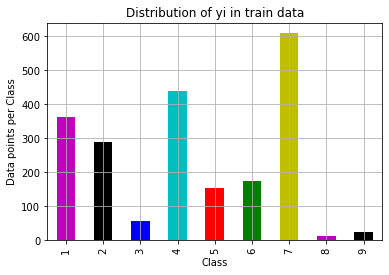

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)


In [12]:
train_class_distribution = x_train['Class'].value_counts().sort_index()
test_class_distribution = X_test['Class'].value_counts().sort_index()
cv_class_distribution = x_cv['Class'].value_counts().sort_index()

my_colors = set('rgbkymc')
train_class_distribution.plot(kind='bar', color = my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): The minus sign will give us in decreasing order
sorted_y = np.argsort(-train_class_distribution.values)
for i in sorted_y:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', 
      np.round((train_class_distribution.values[i]/x_train.shape[0]*100), 3), '%)')

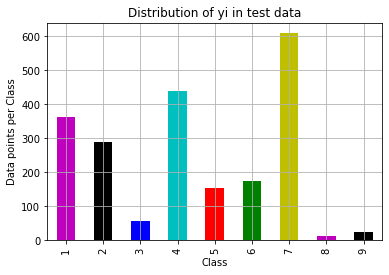

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)


In [13]:
my_colors = set('rgbkymc')
train_class_distribution.plot(kind='bar', color = my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): The minus sign will give us in decreasing order
sorted_y = np.argsort(-test_class_distribution.values)
for i in sorted_y:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', 
      np.round((test_class_distribution.values[i]/X_test.shape[0]*100), 3), '%)')

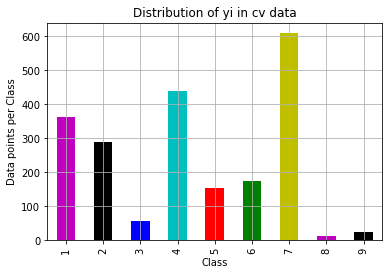

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


In [14]:
my_colors = set('rgbkymc')
train_class_distribution.plot(kind='bar', color = my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cv data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): The minus sign will give us in decreasing order
sorted_y = np.argsort(-cv_class_distribution.values)
for i in sorted_y:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', 
      np.round((cv_class_distribution.values[i]/x_cv.shape[0]*100), 3), '%)')

**From the above visualisation we can conclude that the class 7 is the most dominating class followed by 4,1 and 2**

In [15]:
def plot_confusion_matrix(test_y, predict_y):
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    C = confusion_matrix(test_y, predict_y)
    
    # Divide each element of the confusion matrix with the sum of elements in that column
    A = (((C.T)/(C.sum(axis=1))).T)
    
    # Divide each element of the confusion matrix with the sum of elements in that row
    B =(C/C.sum(axis=0))
    
    labels = [1,2,3,4,5,6,7,8,9]
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sn.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sn.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sn.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Log loss on Cross Validation Data using Random Model 2.4790834907947845
Log loss on Test Data using Random Model 2.402357075377274
-------------------- Confusion matrix --------------------


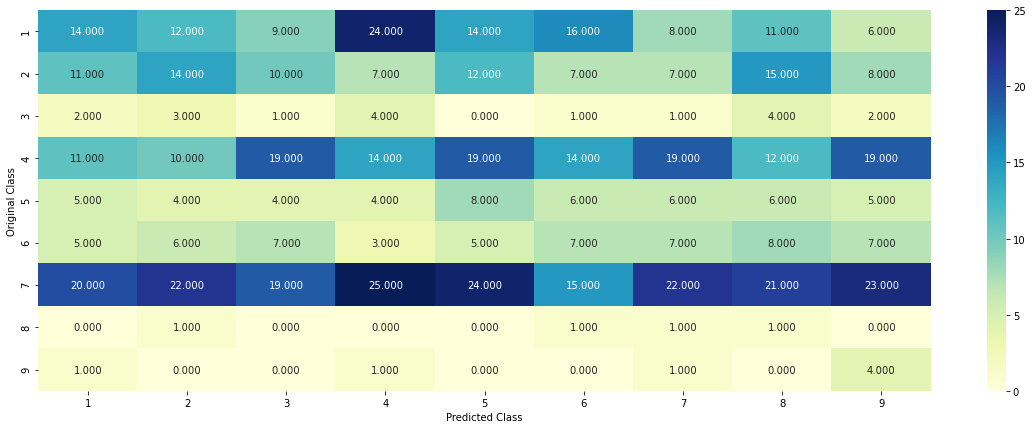

-------------------- Precision matrix (Columm Sum=1) --------------------


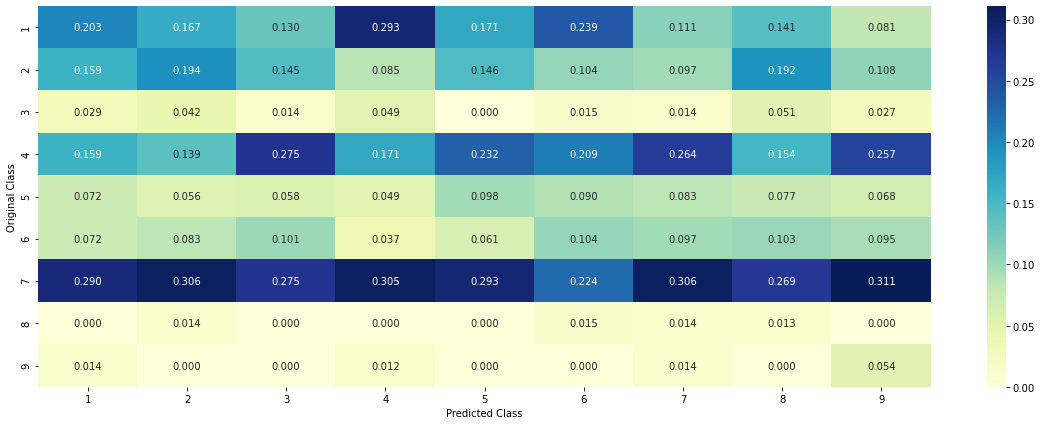

-------------------- Recall matrix (Row sum=1) --------------------


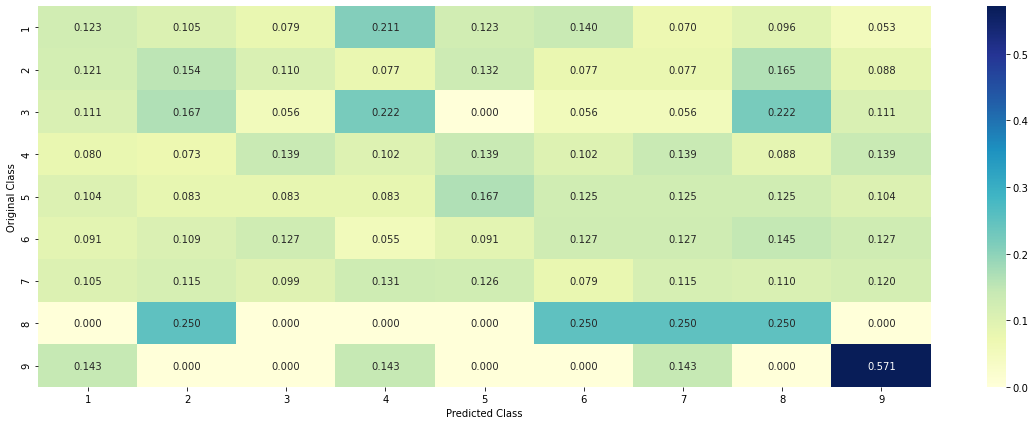

In [16]:
# We need to generate 9 numbers and the sum of numbers should be 1
# One solution is to generate 9 numbers and divide each of the numbers by their sum
# Ref: https://stackoverflow.com/a/18662466/4084039
test_data_len = X_test.shape[0]
cv_data_len = x_cv.shape[0]

# We create an output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9)) #Creating an array of length 9 with all zeros : [0,0,0,0,0,0,0,0,0,0]
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9) #randomly generating the class from 1 to 9
     # getting the probability value for each class i.e. if class 1 is occuring 25 times and class 2 is occuring 30 times then probability is [1/25,2/30,....9/n]
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model", log_loss(y_cv,cv_predicted_y, eps=1e-15))

# We create an output array that has exactly same size as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model", log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y = np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

In [17]:
# Code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['x_train', 'X_test', 'x_cv']
# algorithm
# ----------
# Consider all unique values and the number of occurences of given feature in train data dataframe.
# Build a vector (1*9), the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# For a value of feature in df:
# If it is in train data:
# We add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# If it is not there in train:
# We add [1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

# get_gv_fea_dict: Get Gene Variation Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(x_train['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    value_count = x_train[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # Denominator will contain the number of times that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(x_train.loc[(x_train['Class']==1) & (x_train['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = x_train.loc[(x_train['Class']==k) & (x_train[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # We are adding the gene/variation to the dict as key and vec as value
        gv_dict[i] = vec
    return gv_dict

# Get Gene Variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788], 
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837], 
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816], 
    #      'BRCA2': [0.13333333333333333, 0.060606060606060608, 0.060606060606060608, 0.078787878787878782, 0.1393939393939394, 0.34545454545454546, 0.060606060606060608, 0.060606060606060608, 0.060606060606060608], 
    #      'PTEN': [0.069182389937106917, 0.062893081761006289, 0.069182389937106917, 0.46540880503144655, 0.075471698113207544, 0.062893081761006289, 0.069182389937106917, 0.062893081761006289, 0.062893081761006289], 
    #      'KIT': [0.066225165562913912, 0.25165562913907286, 0.072847682119205295, 0.072847682119205295, 0.066225165562913912, 0.066225165562913912, 0.27152317880794702, 0.066225165562913912, 0.066225165562913912], 
    #      'BRAF': [0.066666666666666666, 0.17999999999999999, 0.073333333333333334, 0.073333333333333334, 0.093333333333333338, 0.080000000000000002, 0.29999999999999999, 0.066666666666666666, 0.066666666666666666],
    #      ...
    #     }
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # For every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # If not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in gv_dict.keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return gv_fea

## Univariate Analysis on Gene Feature

In [18]:
unique_genes = x_train['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])

# Top 10 most frequent genes
print(unique_genes.head(10))

print("There are", unique_genes.shape[0] ,"different categories of genes in the train data, and they are distibuted as follows")

Number of Unique Genes : 238
BRCA1     173
TP53      104
EGFR       90
BRCA2      87
PTEN       83
BRAF       62
KIT        61
ALK        47
ERBB2      42
PDGFRA     39
Name: Gene, dtype: int64
There are 238 different categories of genes in the train data, and they are distibuted as follows


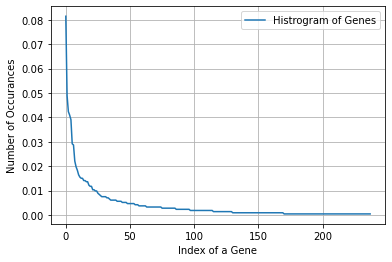

In [19]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

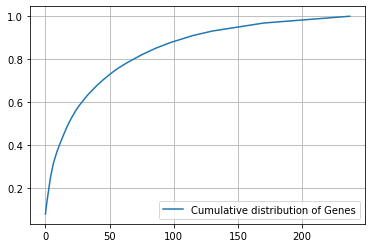

In [20]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

In [21]:
# Response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# Train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", x_train))
# Test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", X_test))
# Cross-Validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", x_cv))

print("train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", train_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (2124, 9)


In [22]:
# One-hot encoding of gene feature
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(x_train['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(X_test['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(x_cv['Gene'])

In [23]:
x_train['Gene'].head()

3096    NOTCH2
872     PDGFRA
880     PDGFRA
1141       MET
2255      PTEN
Name: Gene, dtype: object

In [24]:
gene_vectorizer.get_feature_names()

C:\Users\anand\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1a',
 'arid1b',
 'arid2',
 'arid5b',
 'asxl1',
 'atm',
 'atrx',
 'aurka',
 'aurkb',
 'axin1',
 'axl',
 'b2m',
 'bap1',
 'bard1',
 'bcl10',
 'bcl2',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk8',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cdkn2c',
 'cebpa',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'dusp4',
 'egfr',
 'elf3',
 'ep300',
 'epas1',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fam58a',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgf19',
 'fgf3',
 'fgf4',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt1',
 'flt3',
 'foxa1',
 'foxl2',
 'foxo1',
 'foxp1',
 'gata3',
 'gli1',
 'gna11',
 'gnaq',
 'gnas',
 'h3f3a',
 'hla',
 'hnf1a',
 'hras',
 'idh1

In [25]:
print("train_gene_feature_onehotCoding is converted feature using respone coding method. The shape of gene feature:", train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using respone coding method. The shape of gene feature: (2124, 238)


### How good is 'Gene' fature in predicting y?

**Here we are seeing that how good Gene feature is in predicting y. So we are building a simple model to get the log-loss of Gene feature for predicting y. If the log-loss is less than the Random/Dumb Model we will keep the Gene feature otherwise discard it.**

For values of alpha: 1e-05 The log loss is: 1.2260776888779321
For values of alpha: 0.0001 The log loss is: 1.205433457230627
For values of alpha: 0.001 The log loss is: 1.238668342648226
For values of alpha: 0.01 The log loss is: 1.3554947133699928
For values of alpha: 0.1 The log loss is: 1.4534655536808516
For values of alpha: 1 The log loss is: 1.4931967138585998


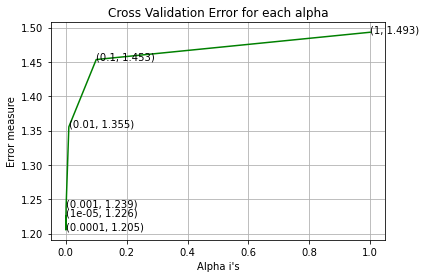

For values of best alpha: 0.0001 The train log loss is: 0.9793798688969781
For values of best alpha: 0.0001 The cross validation log loss is: 1.205433457230627
For values of best alpha: 0.0001 The test log loss is: 1.19290251412189


In [26]:
alpha = [10 ** x for x in range(-5,1)] #hyperparameter for SGD Classifier

cv_log_error_array=[]
for i in alpha:
    #Using SGD Classifier as Logistic Classifier
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    #Using Calibrated Classifier to get the probabilities for 'y'
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha:', i, "The log loss is:", log_loss(y_cv, predict_y, labels = clf.classes_, eps = 1e-15))
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, color = 'g')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], np.round(txt, 3)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha:', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha:', alpha[best_alpha], "The cross validation log loss is:", log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha:', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

**By looking at the log-loss values for train,cv,test data we can conclude that 'Gene' feature is stable and can be used to predict 'y'.**

## Univariate Analysis on "Variation" feature

In [27]:
unique_variation = x_train['Variation'].value_counts()
print('Number of unique Variations :', unique_variation.shape[0])
# top 10 variations 
unique_variation.head(10)

Number of unique Variations : 1932


Truncating_Mutations    55
Deletion                49
Amplification           48
Fusions                 19
Q61L                     3
Q61H                     3
Overexpression           3
G12C                     2
Y42C                     2
R170W                    2
Name: Variation, dtype: int64

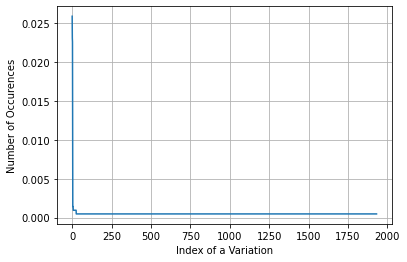

In [28]:
s = sum(unique_variation.values)
h = unique_variation.values/s
plt.plot(h, label = 'Histogram of Variation')
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurences')
plt.grid()
plt.show()

[0.02589454 0.04896422 0.07156309 ... 0.99905838 0.99952919 1.        ]


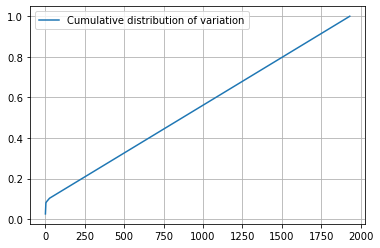

In [29]:
c = np.cumsum(h)
print(c)
plt.plot(c,label = 'Cumulative distribution of variation')
plt.grid()
plt.legend()
plt.show()

In [30]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", x_train))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", X_test))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", x_cv))

print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:", train_variation_feature_responseCoding.shape)

train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature: (2124, 9)


In [31]:
# One-hot encoding of variation feature
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(x_train['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(X_test['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(x_cv['Variation'])

For values of alpha: 1e-05 The log loss is: 1.7039756700809647
For values of alpha: 0.0001 The log loss is: 1.6938836093951315
For values of alpha: 0.001 The log loss is: 1.6938016524649275
For values of alpha: 0.01 The log loss is: 1.702037654761509
For values of alpha: 0.1 The log loss is: 1.7201853028436238
For values of alpha: 1 The log loss is: 1.7207841459118793


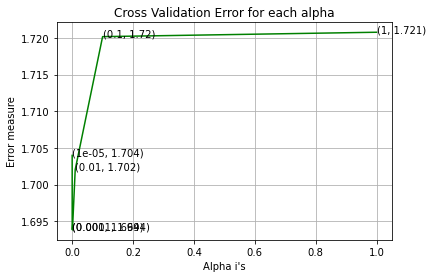

For values of best alpha: 0.001 The train log loss is: 1.0938000111855064
For values of best alpha: 0.001 The cross validation log loss is: 1.6938016524649275
For values of best alpha: 0.001 The test log loss is: 1.6965490076795238


In [32]:
alpha = [10 ** x for x in range(-5,1)] #hyperparameter for SGD Classifier

cv_log_error_array=[]
for i in alpha:
    #Using SGD Classifier as Logistic Classifier
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    #Using Calibrated Classifier to get the probabilities for 'y'
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha:', i, "The log loss is:", log_loss(y_cv, predict_y, labels = clf.classes_, eps = 1e-15))
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, color = 'g')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], np.round(txt, 3)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha:', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha:', alpha[best_alpha], "The cross validation log loss is:", log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha:', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

**There is huge difference between the train and cv, test log-loss. Hence we can conclude that variation feature is NOT STABLE but as the loss is less than the loss of random/dumb model we can keep this feature.**

## Univariate Analysis of 'TEXT' Feature

In [33]:
# cls_text is a data frame
# For every row in data-frame consider the 'TEXT'
# Split the words by space
# Make a dict with those words
# Increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

### Response Coding of TEXT Feature

In [34]:
import math
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(( (dict_list[i].get(word,0)+10) / (total_dict.get(word,0)+90) ))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [35]:
# Building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df = 3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(x_train['TEXT'])

# Getting all the feature names (words)
train_text_features = text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with the number of times it occured
text_fea_dict = dict(zip(list(train_text_features), train_text_fea_counts))

print("Total number of unique words in train data:", len(train_text_features))

Total number of unique words in train data: 53600


C:\Users\anand\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [36]:
# dict_list = [] contains 9 dictoinaries each corresponds to a class
dict_list = []

for i in range(1,10):
    # Build a word dict based on the words in that class
    cls_text = x_train[x_train['Class']==i]
    # Append it to dict_list
    dict_list.append(extract_dictionary_paddle(cls_text))

# dict_list[i] is build on i'th  class text data
# total_dict is build on whole training text data
total_dict = extract_dictionary_paddle(x_train)

confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append( (dict_list[j][i]+10) / (total_dict[i]+90) )
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [37]:
# Response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(x_train)
test_text_feature_responseCoding  = get_text_responsecoding(X_test)
cv_text_feature_responseCoding  = get_text_responsecoding(x_cv)

In [38]:
# We convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

**Normalising the data**

In [39]:
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# We use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(X_test['TEXT'])
# Don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# We use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(x_cv['TEXT'])
# Don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [40]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [41]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({3: 5288, 4: 4014, 6: 2856, 5: 2672, 9: 2162, 7: 1960, 8: 1824, 10: 1472, 12: 1361, 11: 1176, 16: 1041, 14: 876, 13: 845, 15: 740, 18: 715, 20: 643, 24: 602, 17: 588, 21: 527, 25: 515, 22: 499, 19: 499, 27: 376, 23: 375, 28: 348, 30: 329, 33: 325, 49: 321, 26: 318, 36: 301, 29: 261, 31: 260, 32: 256, 51: 255, 35: 255, 40: 240, 42: 227, 34: 213, 37: 212, 48: 200, 39: 194, 46: 180, 38: 178, 56: 169, 43: 169, 41: 164, 45: 159, 44: 156, 50: 153, 52: 145, 54: 144, 60: 143, 47: 143, 58: 142, 63: 138, 57: 132, 55: 121, 53: 121, 64: 117, 66: 110, 73: 109, 62: 108, 61: 108, 59: 107, 67: 100, 69: 95, 72: 93, 77: 91, 65: 91, 70: 90, 80: 87, 68: 87, 76: 83, 92: 82, 74: 79, 84: 78, 82: 76, 88: 75, 99: 73, 86: 73, 81: 72, 78: 72, 71: 72, 75: 70, 93: 68, 87: 67, 96: 66, 85: 66, 102: 65, 83: 64, 79: 64, 107: 63, 89: 63, 120: 62, 94: 62, 100: 61, 95: 61, 105: 59, 98: 56, 91: 54, 101: 53, 90: 53, 126: 50, 113: 50, 103: 49, 110: 48, 106: 48, 112: 47, 97: 47, 116: 46, 135: 44, 114: 44, 109: 44, 10

For values of alpha =  1e-05 The log loss is: 1.2802606890024366
For values of alpha =  0.0001 The log loss is: 1.1369447863517776
For values of alpha =  0.001 The log loss is: 1.1167713294558828
For values of alpha =  0.01 The log loss is: 1.2433822846804237
For values of alpha =  0.1 The log loss is: 1.4446393360098773
For values of alpha =  1 The log loss is: 1.6395941464544121


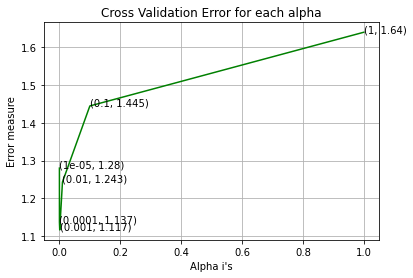

For values of best alpha =  0.001 The train log loss is: 0.6848013789594505
For values of best alpha =  0.001 The cross validation log loss is: 1.1167713294558828
For values of best alpha =  0.001 The test log loss is: 1.0908326668330404


In [42]:
# Train a Logistic Regression + Calibration model using text features which are one-hot encoded
alpha = [10 ** x for x in range(-5, 1)]
cv_log_error_array=[]

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

**As we can see the 'Text' feature has significantly lower log-loss and the difference between train and test, cv log-loss is quite low, hence this feature is stable.**

# Machine Learning Models

In [43]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # For calculating log_loss, we will provide the array of probabilities belonging to each class
    print("Log loss:", log_loss(test_y, sig_clf.predict_proba(test_x)))
    # Calculating the number of data points that are misclassified
    print("Number of mis-classified points:", np.count_nonzero((pred_y-test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [44]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [45]:
# This function will be used just for naive bayes
# For the given indices, we will print the name of the features
# And we will check whether the feature is present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(x_train['Gene'])
    var_vec  = var_count_vec.fit(x_train['Variation'])
    text_vec = text_count_vec.fit(x_train['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top", no_features, "features", word_present, "are present in query point")

## Stacking three features - Gene, Variation, Text

In [46]:
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(x_train['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(X_test['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(x_cv['Class']))

In [47]:
print("One-hot encoding features:")
print("(Number of data points * Number of features) in train data =", train_x_onehotCoding.shape)
print("(Number of data points * Number of features) in test data =", test_x_onehotCoding.shape)
print("(Number of data points * Number of features) in cross-validation data =", cv_x_onehotCoding.shape)


One-hot encoding features:
(Number of data points * Number of features) in train data = (2124, 55798)
(Number of data points * Number of features) in test data = (665, 55798)
(Number of data points * Number of features) in cross-validation data = (532, 55798)


**We can see that dimensinality is very large in OHE. We can try algorithms like Logistic Regression, Linear SVM.**

In [48]:
train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

In [49]:
print("Response encoding features :")
print("(Number of data points * Number of features) in train data = ", train_x_responseCoding.shape)
print("(Number of data points * Number of features) in test data = ", test_x_responseCoding.shape)
print("(Number of data points * Number of features) in cross-validation data =", cv_x_responseCoding.shape)

Response encoding features :
(Number of data points * Number of features) in train data =  (2124, 27)
(Number of data points * Number of features) in test data =  (665, 27)
(Number of data points * Number of features) in cross-validation data = (532, 27)


**Dimensionality is low in response coding. We can try algorithms like K-NN, Decision Trees, Random Forest, etc**

## Baseline Model - Naive Bayes

For alpha = 1e-05
Log Loss: 1.27140188010265
For alpha = 0.0001
Log Loss: 1.2731253415868085
For alpha = 0.001
Log Loss: 1.269957390549838
For alpha = 0.1
Log Loss: 1.2633712189114774
For alpha = 1
Log Loss: 1.3049957004790544
For alpha = 10
Log Loss: 1.4072409974823428
For alpha = 100
Log Loss: 1.396450209679231
For alpha = 1000
Log Loss: 1.3393879376660416


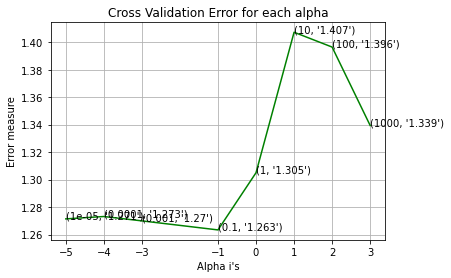

For values of best alpha =  0.1 The train log loss is: 0.8759802956513828
For values of best alpha =  0.1 The cross-validation log loss is: 1.2633712189114774
For values of best alpha =  0.1 The test log loss is: 1.274773922765754


In [50]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # To avoid rounding error while multiplying probabilites, we use log-probability estimates
    print("Log Loss:", log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
    
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:", log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

##### Testing the model with best hyper paramters

Log Loss: 1.2633712189114774
Number of mis-classified points: 0.39849624060150374


C:\Users\anand\AppData\Local\Temp/ipykernel_13352/2979579373.py:9: RuntimeWarning: invalid value encountered in true_divide
  B =(C/C.sum(axis=0))


-------------------- Confusion matrix --------------------


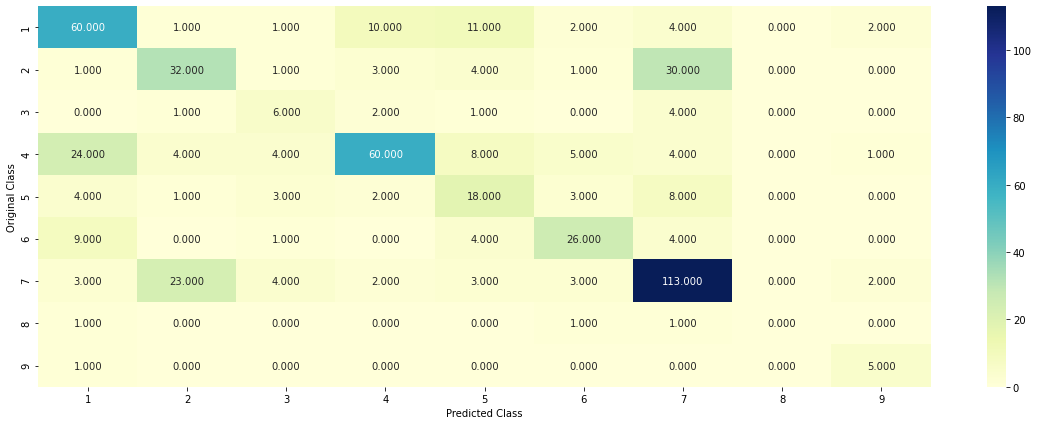

-------------------- Precision matrix (Columm Sum=1) --------------------


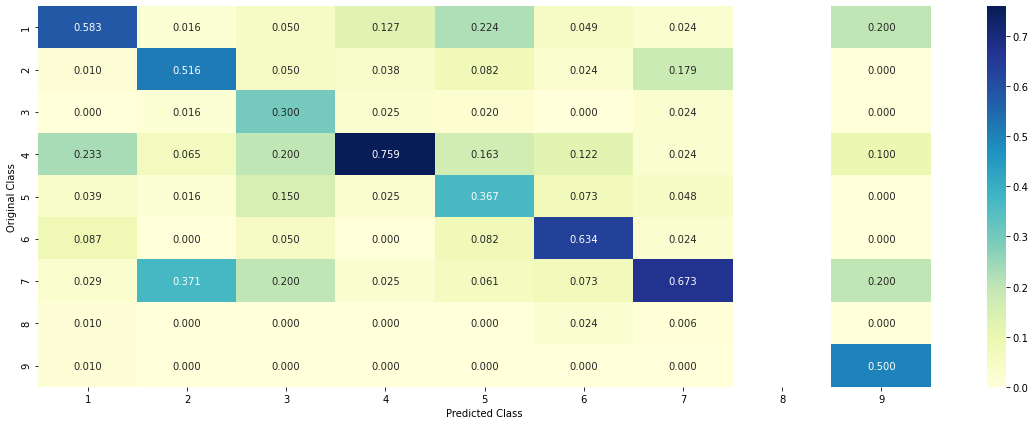

-------------------- Recall matrix (Row sum=1) --------------------


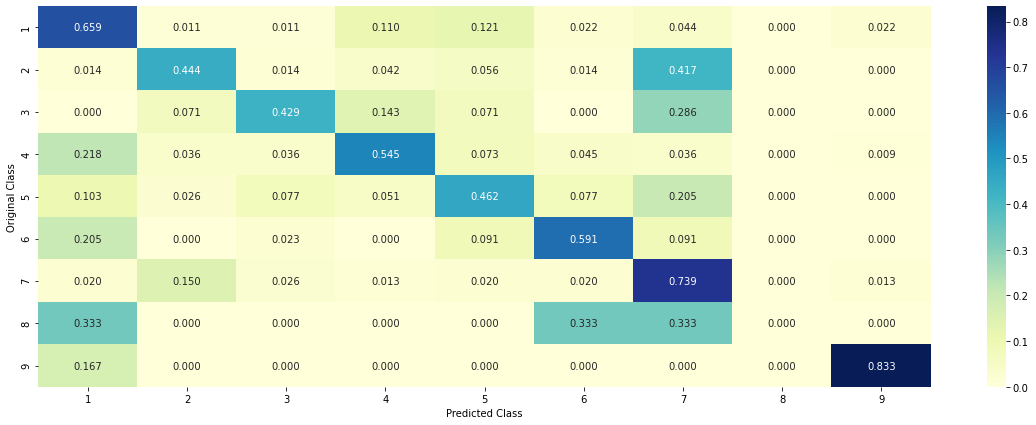

In [51]:
clf = MultinomialNB(alpha = alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)

# To avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss:", log_loss(cv_y, sig_clf_probs))
print("Number of mis-classified points:", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

##### Feature Importance, Correctly classified point

In [52]:
test_point_index = 0
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class:", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class:", y_test[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['TEXT'].iloc[test_point_index],
    X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class: 1
Predicted Class Probabilities: [[0.5691 0.0771 0.0169 0.1133 0.0346 0.0389 0.1396 0.0063 0.0041]]
Actual Class: 1
--------------------------------------------------


C:\Users\anand\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)
C:\Users\anand\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Out of the top 500 features 0 are present in query point


##### Feature Importance, Incorrectly classified point

In [53]:
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['TEXT'].iloc[test_point_index],
    X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.157  0.2189 0.0278 0.186  0.0567 0.0662 0.2344 0.0459 0.0071]]
Actual Class : 1
--------------------------------------------------
Out of the top 500 features 0 are present in query point


## KNN Classification

For alpha = 5
Log Loss: 1.0475912261771976
For alpha = 11
Log Loss: 1.0521103781300662
For alpha = 15
Log Loss: 1.0543185851944183
For alpha = 21
Log Loss: 1.075991159661152
For alpha = 31
Log Loss: 1.0881105673517704
For alpha = 41
Log Loss: 1.0878463228004582
For alpha = 51
Log Loss: 1.1032801399577117
For alpha = 99
Log Loss: 1.1319163099063858


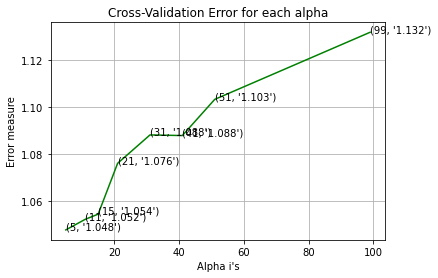

For values of best alpha = 5 The train log loss is: 0.4428894662224581
For values of best alpha = 5 The cross-validation log loss is: 1.0475912261771976
For values of best alpha = 5 The test log loss is: 1.0473058667929955


In [54]:
from sklearn.neighbors import KNeighborsClassifier 
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # To avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss:", log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross-Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha =', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha =', alpha[best_alpha], "The cross-validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha =', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

##### Testing the model with best hyper paramters¶


Log loss: 1.0475912261771976
Number of mis-classified points: 0.34962406015037595
-------------------- Confusion matrix --------------------


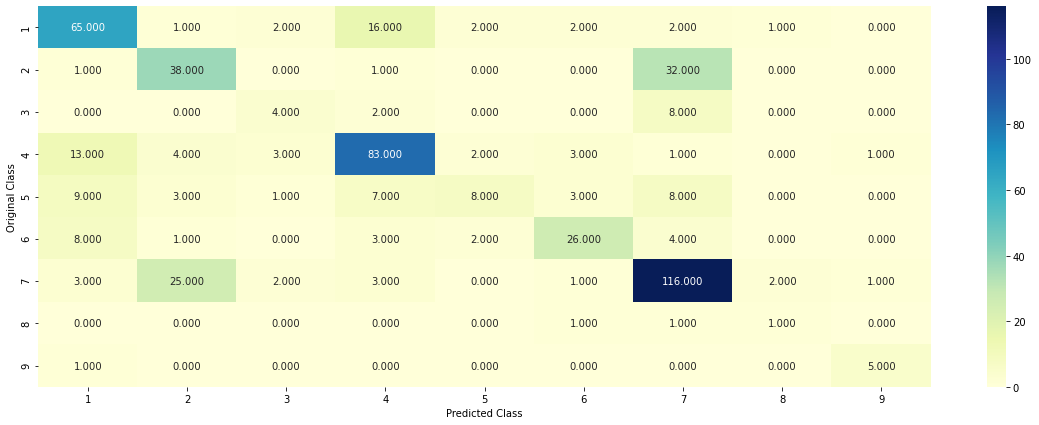

-------------------- Precision matrix (Columm Sum=1) --------------------


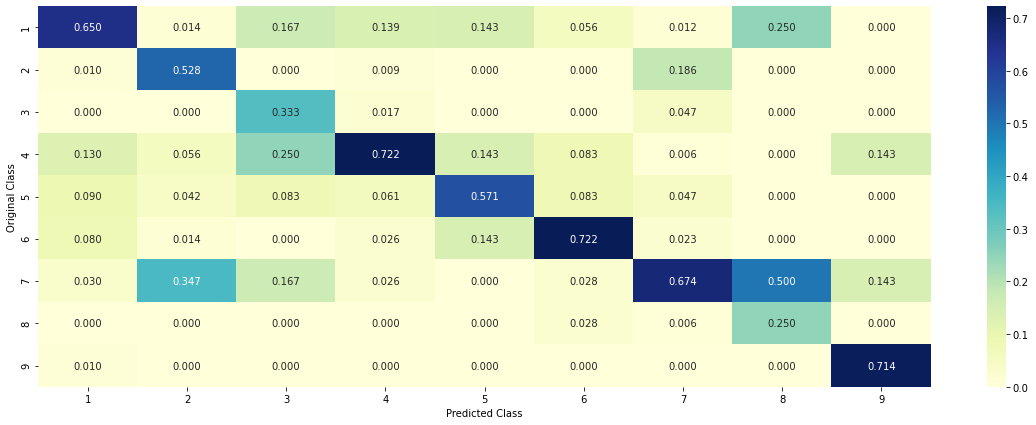

-------------------- Recall matrix (Row sum=1) --------------------


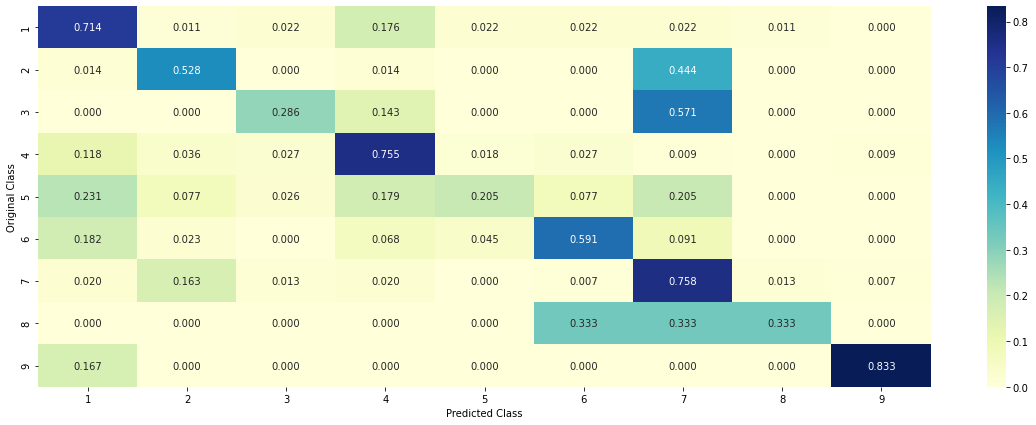

In [55]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

##### Sample Query point - 1

In [57]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class:", predicted_cls[0])
print("Actual Class:", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The", alpha[best_alpha]," nearest neighbours of the test points belongs to classes", train_y[neighbors[1][0]])
print("Fequency of nearest points:", Counter(train_y[neighbors[1][0]]))

Predicted Class: 1
Actual Class: 1
The 5  nearest neighbours of the test points belongs to classes [1 1 1 4 4]
Fequency of nearest points: Counter({1: 3, 4: 2})


##### Sample Query Point - 2

In [58]:
clf = KNeighborsClassifier(n_neighbors = alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class:", predicted_cls[0])
print("Actual Class:", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The k value for KNN is",alpha[best_alpha], "and the nearest neighbours of the test points belongs to classes", train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class: 2
Actual Class: 5
The k value for KNN is 5 and the nearest neighbours of the test points belongs to classes [7 2 7 2 2]
Fequency of nearest points : Counter({2: 3, 7: 2})


## Logistic Regression

For alpha = 1e-06
Log Loss: 1.3296873012621857
For alpha = 1e-05
Log Loss: 1.2828181624502377
For alpha = 0.0001
Log Loss: 1.0860166626564889
For alpha = 0.001
Log Loss: 1.068031880597461
For alpha = 0.01
Log Loss: 1.1420203657045869
For alpha = 0.1
Log Loss: 1.460104955369656
For alpha = 1
Log Loss: 1.6521643961917956
For alpha = 10
Log Loss: 1.6779860740164316
For alpha = 100
Log Loss: 1.6807460118325461


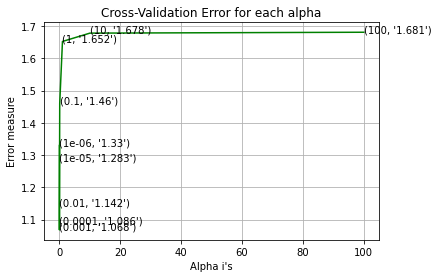

For values of best alpha =  0.001 The train log loss is: 0.5460618491874342
For values of best alpha =  0.001 The cross-validation log loss is: 1.068031880597461
For values of best alpha =  0.001 The test log loss is: 1.0202329794187988


In [59]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42) #class balancing
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # To avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss:", log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross-Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:", log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

##### Testing the model with best hyper-paramters

Log loss: 1.068031880597461
Number of mis-classified points: 0.34022556390977443
-------------------- Confusion matrix --------------------


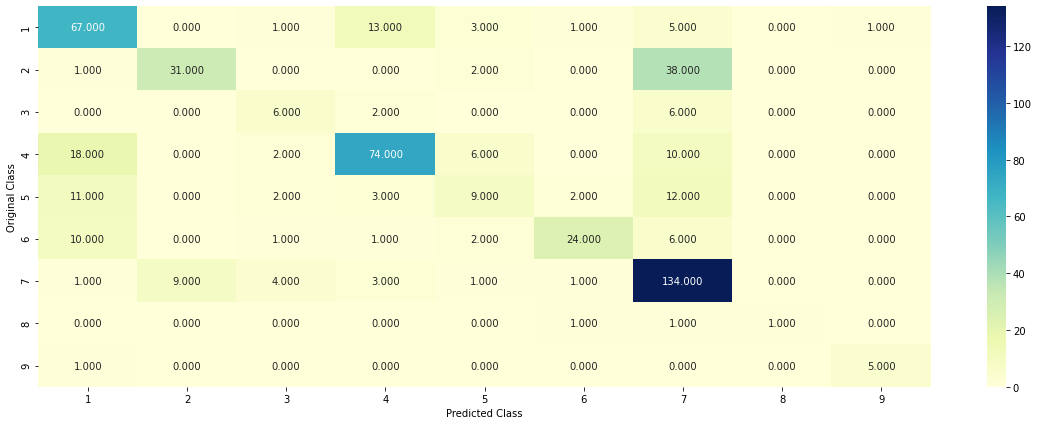

-------------------- Precision matrix (Columm Sum=1) --------------------


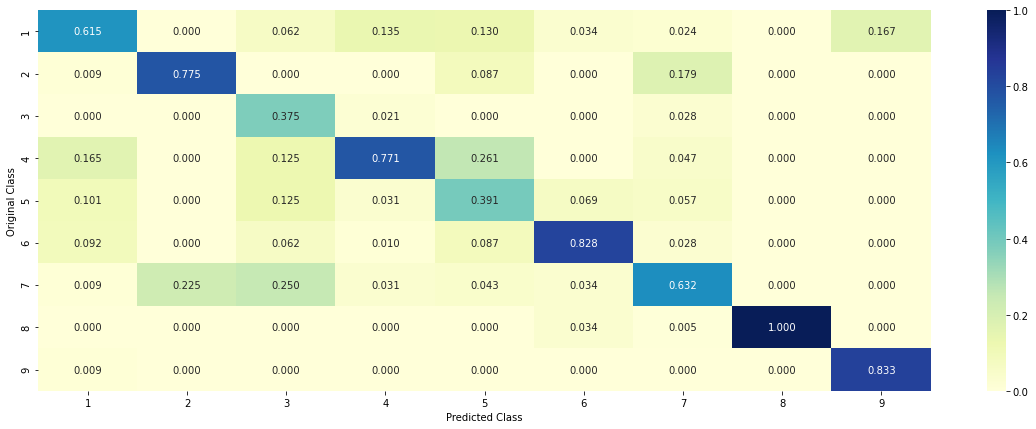

-------------------- Recall matrix (Row sum=1) --------------------


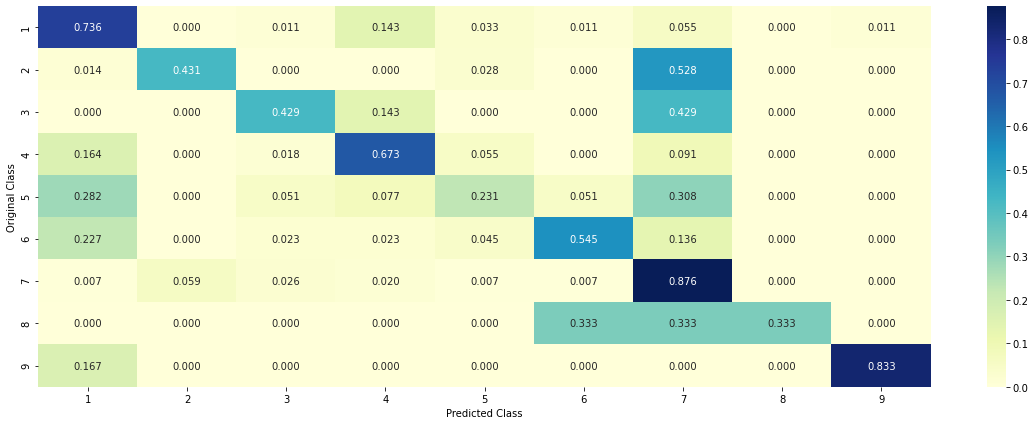

In [60]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

## Linear SVM

for C = 1e-05
Log Loss : 1.291954886760598
for C = 0.0001
Log Loss : 1.2104138388852286
for C = 0.001
Log Loss : 1.1447974953869628
for C = 0.01
Log Loss : 1.1424349984374287
for C = 0.1
Log Loss : 1.3836761848856236
for C = 1
Log Loss : 1.6713537495834765
for C = 10
Log Loss : 1.68117741612455
for C = 100
Log Loss : 1.681178963171496


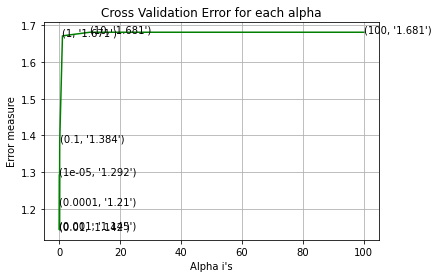

For values of best alpha =  0.01 The train log loss is: 0.7712686456258038
For values of best alpha =  0.01 The cross-validation log loss is: 1.1424349984374287
For values of best alpha =  0.01 The test log loss is: 1.1078177114866912


In [61]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
    # clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

##### Testing model with best hyper-parameters

Log loss: 1.1424349984374287
Number of mis-classified points: 0.35526315789473684
-------------------- Confusion matrix --------------------


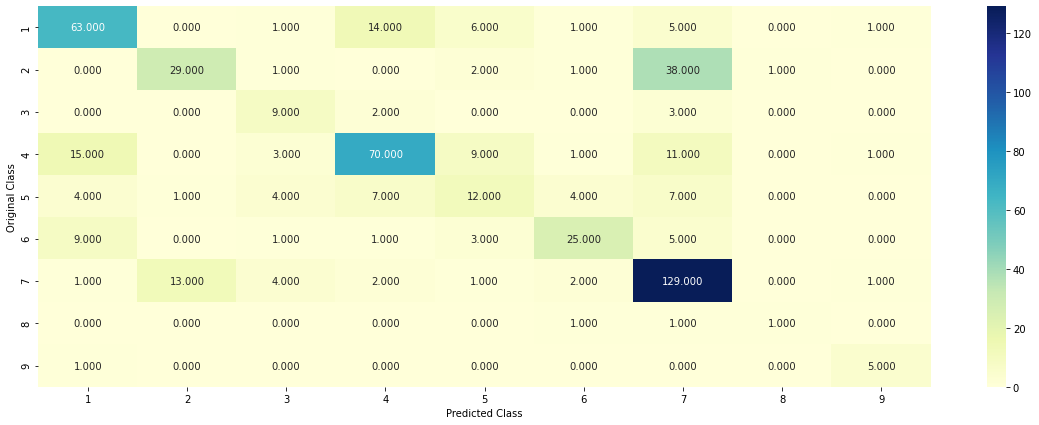

-------------------- Precision matrix (Columm Sum=1) --------------------


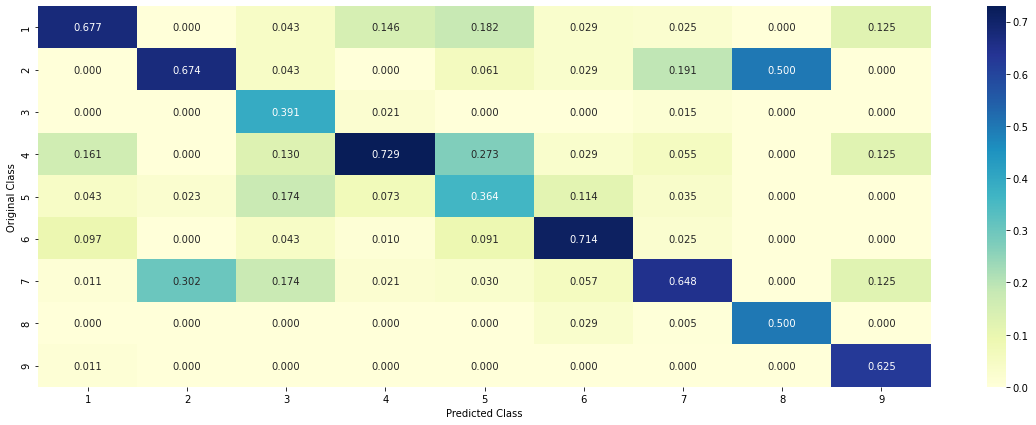

-------------------- Recall matrix (Row sum=1) --------------------


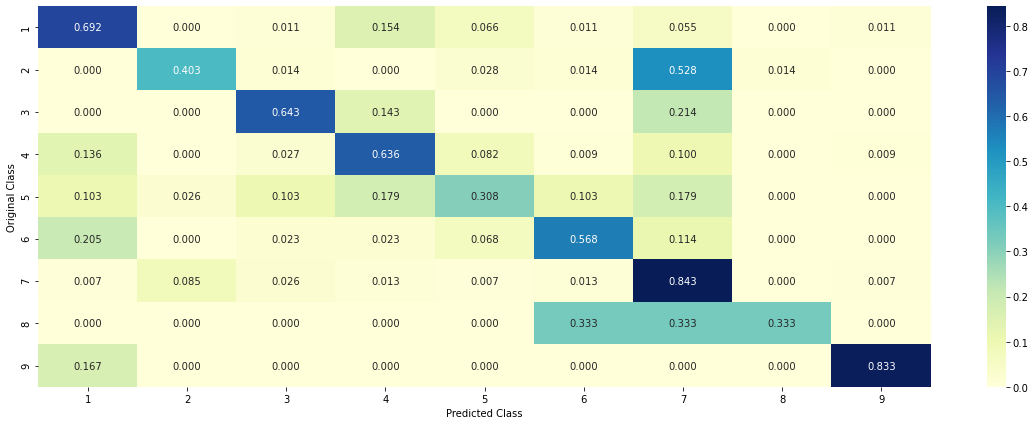

In [62]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42, class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

## Random Forest

**Hyper-parameter tuning (With One Hot Encoding)**

In [63]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []

for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross-validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.300990093255535
for n_estimators = 100 and max depth =  10
Log Loss : 1.200414265732003
for n_estimators = 200 and max depth =  5
Log Loss : 1.2856249251186198
for n_estimators = 200 and max depth =  10
Log Loss : 1.191794802398394
for n_estimators = 500 and max depth =  5
Log Loss : 1.2745912055129869
for n_estimators = 500 and max depth =  10
Log Loss : 1.1906280265059517
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2674669988754694
for n_estimators = 1000 and max depth =  10
Log Loss : 1.188364652665934
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2648310830180514
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1882435681502095
For values of best estimator =  2000 The train log loss is: 0.7084137581161717
For values of best estimator =  2000 The cross-validation log loss is: 1.1882435681502095
For values of best estimator =  2000 The test log loss is: 1.1737179310555201


##### Testing model with best hyper parameters (One Hot Encoding)

Log loss: 1.1882435681502095
Number of mis-classified points: 0.39097744360902253
-------------------- Confusion matrix --------------------


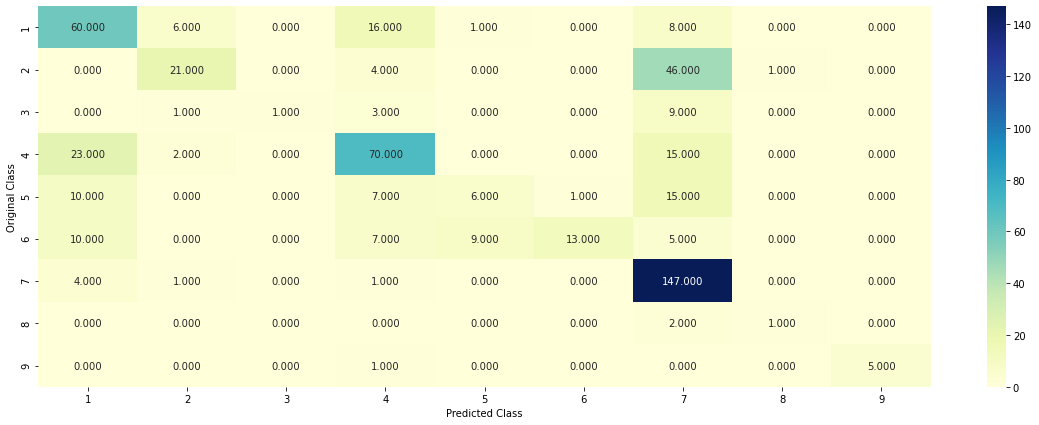

-------------------- Precision matrix (Columm Sum=1) --------------------


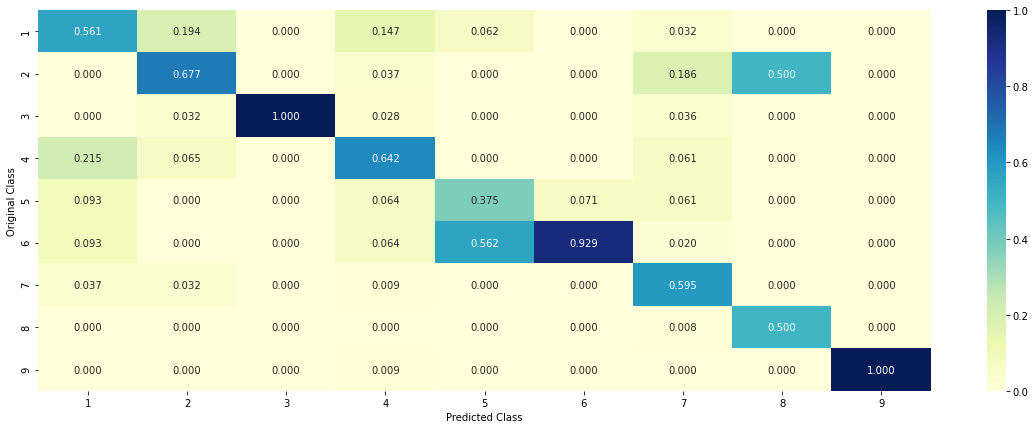

-------------------- Recall matrix (Row sum=1) --------------------


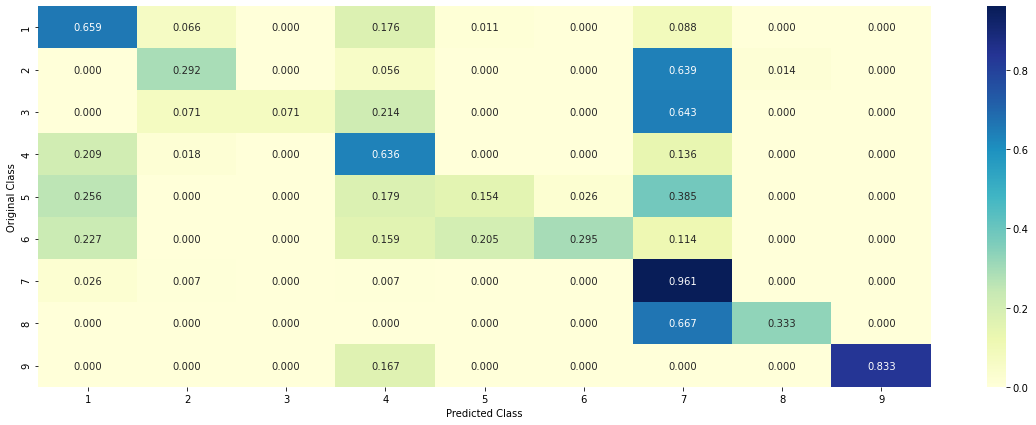

In [64]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

**Hyper-parameter tuning (With Response Coding)**

In [65]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []

for i in alpha:
    for j in max_depth:
        print("For n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross-validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For n_estimators = 10 and max depth =  2
Log Loss : 2.0488046195624245
For n_estimators = 10 and max depth =  3
Log Loss : 1.811890403752497
For n_estimators = 10 and max depth =  5
Log Loss : 1.7305143157015546
For n_estimators = 10 and max depth =  10
Log Loss : 1.836052415157599
For n_estimators = 50 and max depth =  2
Log Loss : 1.6851221870871287
For n_estimators = 50 and max depth =  3
Log Loss : 1.428130115273435
For n_estimators = 50 and max depth =  5
Log Loss : 1.4370723028111627
For n_estimators = 50 and max depth =  10
Log Loss : 1.6777220677342162
For n_estimators = 100 and max depth =  2
Log Loss : 1.5252761457357025
For n_estimators = 100 and max depth =  3
Log Loss : 1.4750640117056293
For n_estimators = 100 and max depth =  5
Log Loss : 1.3391026575488991
For n_estimators = 100 and max depth =  10
Log Loss : 1.6758188374943512
For n_estimators = 200 and max depth =  2
Log Loss : 1.5750853816085468
For n_estimators = 200 and max depth =  3
Log Loss : 1.4845529521293683


##### Testing model with best hyper-parameters (Response Coding)

Log loss: 1.339102657548899
Number of mis-classified points: 0.4849624060150376
-------------------- Confusion matrix --------------------


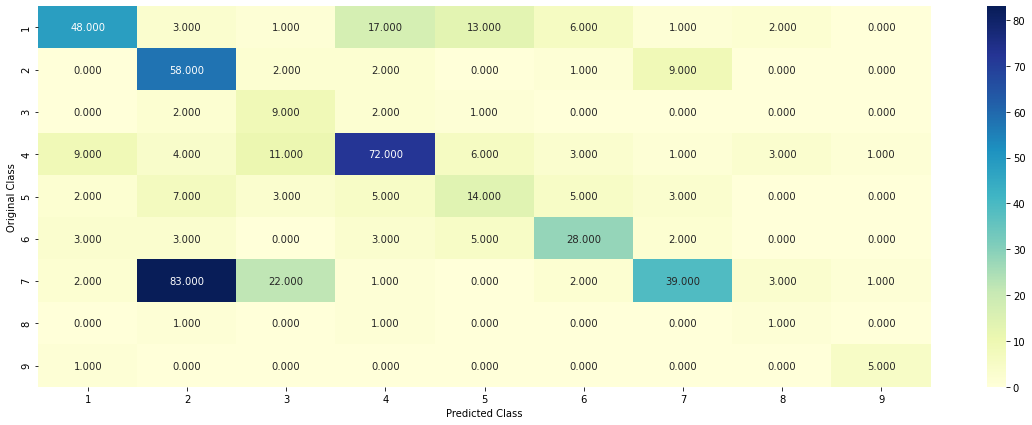

-------------------- Precision matrix (Columm Sum=1) --------------------


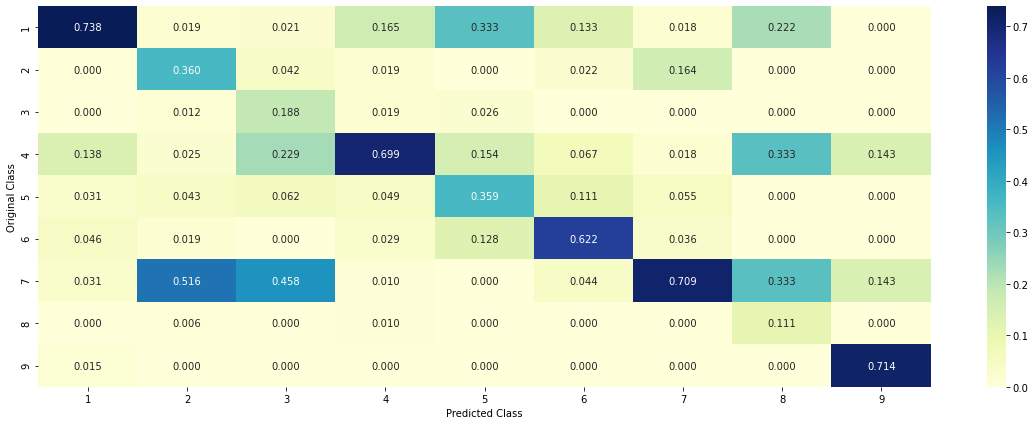

-------------------- Recall matrix (Row sum=1) --------------------


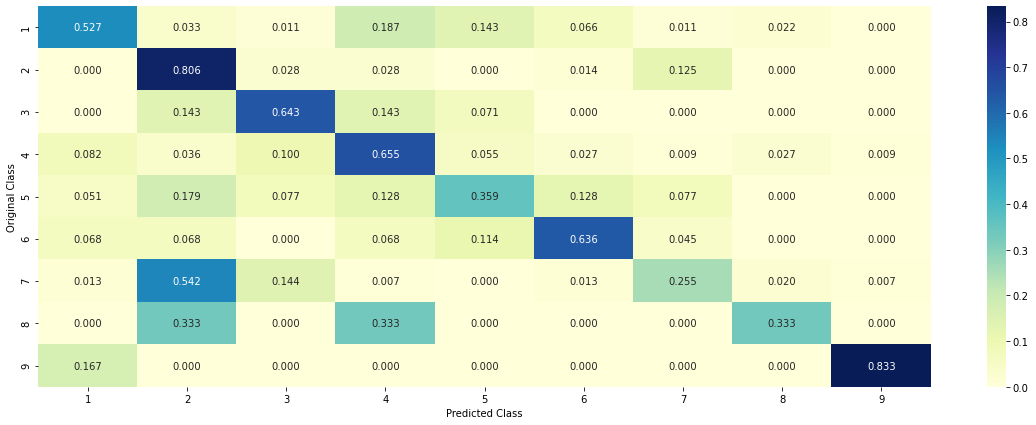

In [66]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

**Here there is too much difference between the train and test,cv log-loss. Also the miss-classification error is very high as compared to others. We can conclude that in this case the Response Coding didnt work well with random forest classifier.**

## Stack the models

In [68]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")

clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)

alpha = [0.0001,0.001,0.01,0.1,1] 
best_loss = 999
best_alpha = 999

for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    print("Stacking Classifer: For the value of alpha: %f Log Loss: %0.3f" % (i, log_error))
    if best_loss > log_error:
        best_loss = log_error
        best_alpha = i

Logistic Regression :  Log Loss: 1.07
Support vector machines : Log Loss: 1.67
Naive Bayes : Log Loss: 1.27
--------------------------------------------------
Stacking Classifer: For the value of alpha: 0.000100 Log Loss: 1.819
Stacking Classifer: For the value of alpha: 0.001000 Log Loss: 1.729
Stacking Classifer: For the value of alpha: 0.010000 Log Loss: 1.339
Stacking Classifer: For the value of alpha: 0.100000 Log Loss: 1.147
Stacking Classifer: For the value of alpha: 1.000000 Log Loss: 1.386


##### Testing the model with the best hyper-parameters

Log loss (train) on the stacking classifier: 0.5138463918507037
Log loss (CV) on the stacking classifier: 1.1465927885484952
Log loss (test) on the stacking classifier: 1.1413971015698599
Number of missclassified points: 0.37293233082706767


C:\Users\anand\AppData\Local\Temp/ipykernel_13352/2979579373.py:9: RuntimeWarning: invalid value encountered in true_divide
  B =(C/C.sum(axis=0))


-------------------- Confusion matrix --------------------


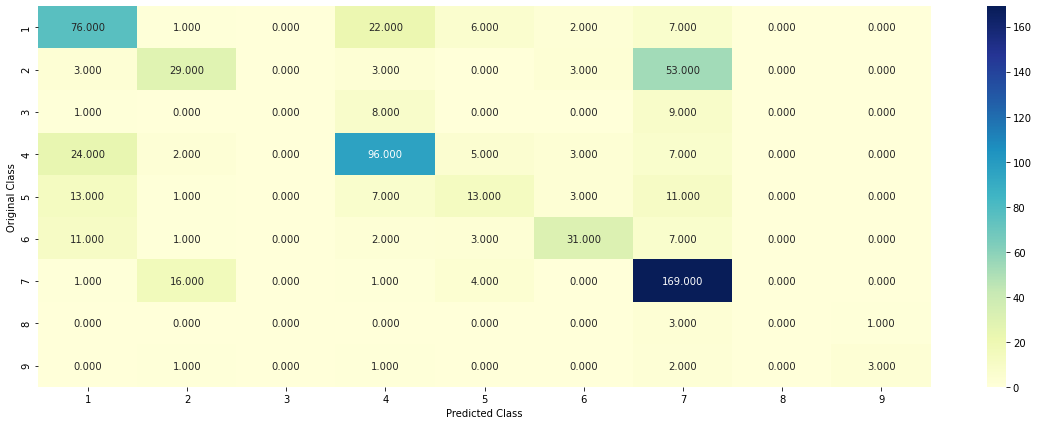

-------------------- Precision matrix (Columm Sum=1) --------------------


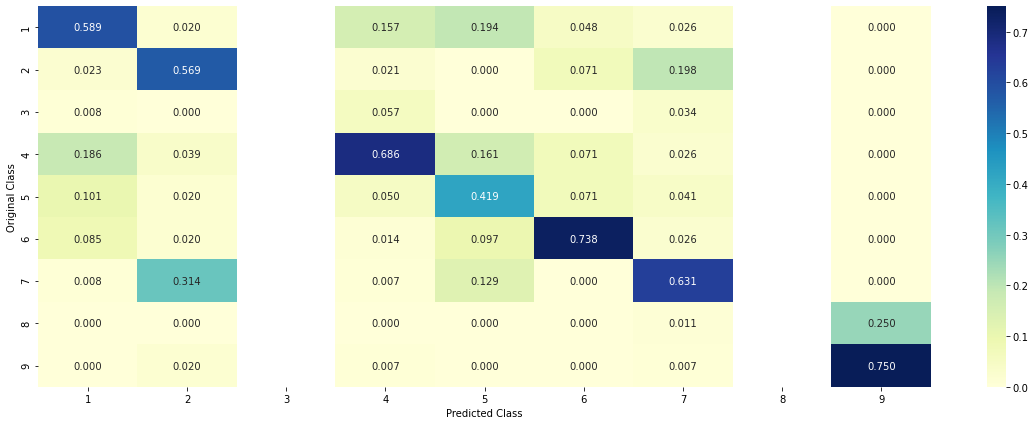

-------------------- Recall matrix (Row sum=1) --------------------


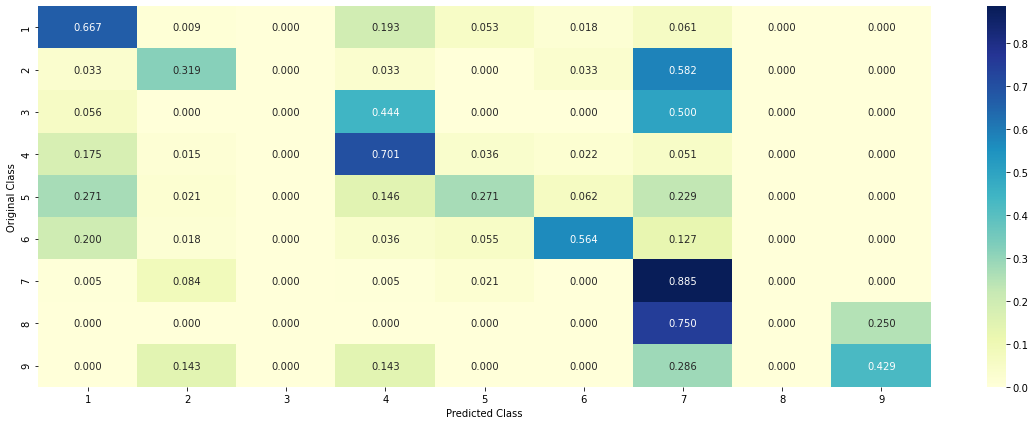

In [70]:
lr = LogisticRegression(C=best_alpha)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier:", log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier:", log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier:", log_error)

print("Number of missclassified points:", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

## Maximum Voting Classifier

Log loss (train) on the VotingClassifier : 0.8805735104293447
Log loss (CV) on the VotingClassifier : 1.1867843313017226
Log loss (test) on the VotingClassifier : 1.1916268855541452
Number of missclassified point : 0.3669172932330827
-------------------- Confusion matrix --------------------


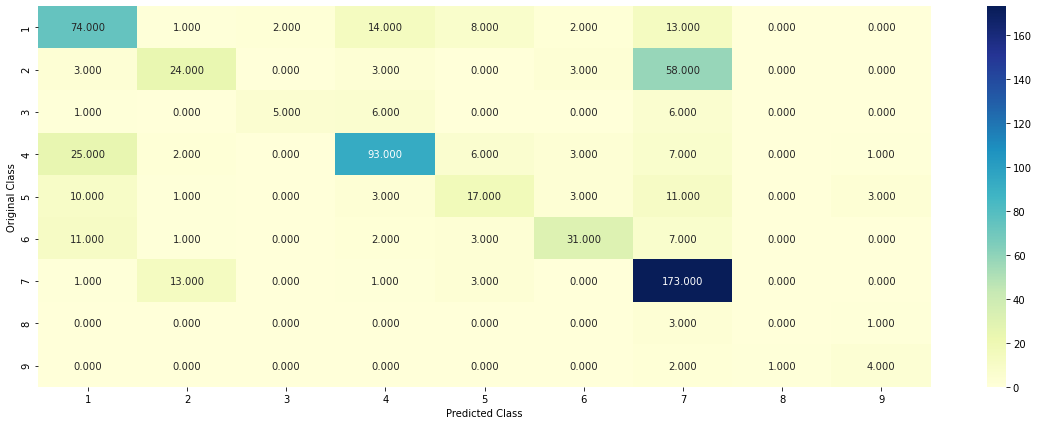

-------------------- Precision matrix (Columm Sum=1) --------------------


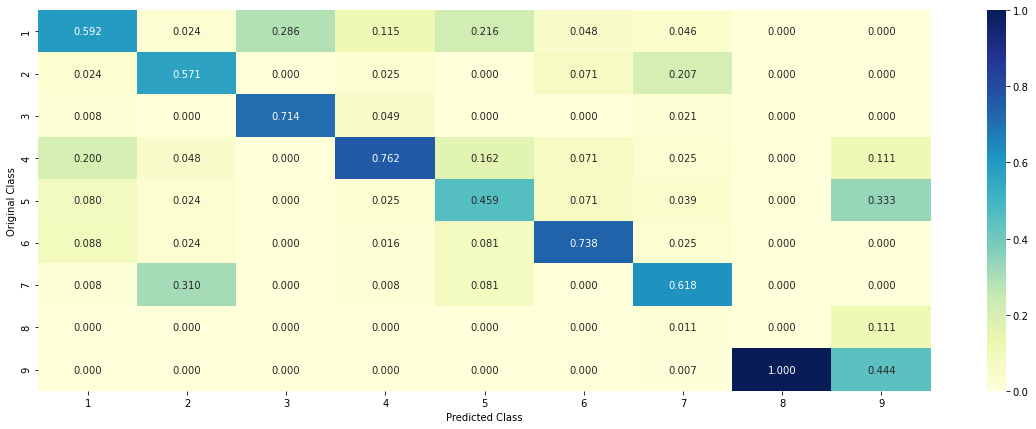

-------------------- Recall matrix (Row sum=1) --------------------


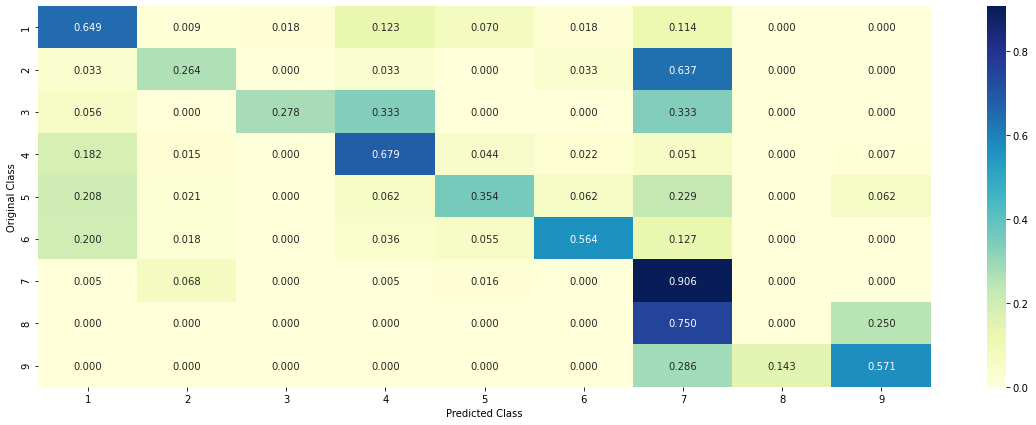

In [71]:
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))

## Models Summary

In [78]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Model", "Attributes", "Train Log-Loss", "CV Log-Loss", "Test Log-Loss","Miss-Classification Error"]
x.add_rows([
    ["Naive Bayes", "OHE + WCB", 0.873, 1.289, 1.284, 0.3984],
    ["KNN", "Response Encoding + WCB", 0.44, 1.04, 1.04, 0.3496],
    ["Logistic Regression", "OHE + CB", 0.546, 1.06, 1.02, 0.3402],
    ["Linear SVM", "OHE + CB", 0.77, 1.14, 1.10, 0.3552],
    ["Random Forest", "OHE", 0.708, 1.18, 1.17, 0.3909],
    ["Random Forest", "Response Coding", 0.064, 1.33, 1.33, 0.4849],
    ["Model Stacking(NB+LR+SVM)", "OHE", 0.51, 1.14, 1.14, 0.3729],
    ["Majority Voting Classifier", "OHE", 0.88, 1.18, 1.19, 0.3669]
])
x

Model,Attributes,Train Log-Loss,CV Log-Loss,Test Log-Loss,Miss-Classification Error
Naive Bayes,OHE + WCB,0.873,1.289,1.284,0.3984
KNN,Response Encoding + WCB,0.44,1.04,1.04,0.3496
Logistic Regression,OHE + CB,0.546,1.06,1.02,0.3402
Linear SVM,OHE + CB,0.77,1.14,1.1,0.3552
Random Forest,OHE,0.708,1.18,1.17,0.3909
Random Forest,Response Coding,0.064,1.33,1.33,0.4849
Model Stacking(NB+LR+SVM),OHE,0.51,1.14,1.14,0.3729
Majority Voting Classifier,OHE,0.88,1.18,1.19,0.3669


### From the Above table we can conclude that
1. The best model for this problem is LogisticRegression where minimum missclassification error is recorded also there is minimum overfitting.
2. Voting Classifier is also a good option because of less misclassification error and less overfitting.
3. Random Forest with Response Coding is overfitting, hence using that model is highly not recommended.
4. KNN with Response Coding is also good as per missclassification error but there is comparatively more overfitting.
5. Linear SVM with OHE+CB can be the best model as well as it does not overfit and there is low difference in missclassification error as compared to LR Voting classifier.